# Welcome to the Brazilian Apocalypse!

We are currently on the second year of the Coronavirus pandemic. It is obvious the institutions aren't ready to face extreme conditions for a prolonged period of time, and neither are the people. While there is a large community of paranoid people in the US who are ready to survive the extinction of civilization, in Brazil this scenario is not something we consider when thinking about the future.

Brazil is a country with continental dimensions, with more than 220 million people spread over 8.5 million square kilometers. There must be some dark forgotten places where one could ride out an extinction level event. There are more than five thousand cities and we will sort through different types of data to determine the best places to enjoy the end of the world.

After ranking the cities from best to worst, we will try to optimize our escape route, choosing our starting city and defining the sequence of cities to get to our final destination. 

## 1. Definition of the problem

There are several different causes for an apocalypse, and people are getting more creative everyday. Zombies, nuclear war, large asteroids, deadly viruses, global warming, exploding volcanoes, massive earthquakes, alien invasion! Although there are huge variations on each of these scenarios, we can look for some information that will help no matter what comes our way. 

Crowded places should be avoided, food must be plentiful, fresh water must be available. We also need medication to cure and prevent diseases, and firearms for protection. It would be smart to be away from nuclear power plants, but solar energy might be useful. Average temperatures around 22 degrees are a good choice. Being close to an airport shoud be interesting, even a small one, for a quick getaway, if you can find and fly a plane. 

We should also be worried about learning new abilities to survive and perhaps rebuild civilization, so we also looking at libraries and universities.

We will load data that helps to determine the potential for each city to fulfill one of this requirements, describing its source and how we create a metric to rank the cities. After processing all this information, our final data set will be a table where each row is a city and each column will show a score between 0 and 1 for a certain feature. Our last feature will be the sum of all scores, and we will rank the cities by this metric. Hopefully, we will have a clear winner for the whole country. 

We also have a list of neighboring cities for each location. So we can map a route from any place to the our sanctuary or try to find the best place at a certain distance from a starting point.

The common feature to all the data will be an ID given by the Brazilian Institute of Geography and Statistics, *IBGE*. This unique ID has six digits, but sometimes databases add an extra number at the end.

## 2. Extraction, Transformation and Loading of the Data

We are gathering here several different information for each Brazilian city. They were all gathered after a long, hard search through several government websites and other sources. We will present the source, the available info and the transformations needed to get our clean table. <br>
Some data was processed before loading here, because of typos or clearly wrong information (Porto Alegre was placed in RN in one of the files).

All the libraries needed will be loaded here.

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import os
import folium
import numpy as np
import haversine as hs

show_maps = False

### 2.1. 2013 Brazilian Human Development Atlas

The Human Development Index (HDI) is a statistic composite index of life expectancy, education, and per capita income indicators. In 2013, the latest report was released, showing the scores for each city, state and the country as a whole, for the years 1990, 2000 and 2010. It can be accessed at <a href="http://www.atlasbrasil.org.br/">Atlas Brasil</a>.

Each row of the table represents a city for one of the given years. There are some ID columns and then all the features that are used to compute the score, the Human Development Index, for each city. From this table, we will need three columns:
1. the city ID;
2. the city population in 2010;
3. the health portion of the HDI in 2010.

The ID will be used as a key to merge all the different data into a single table. The population will be used to compute the population density, and the Health HDI will be used as an indication of how well the city is capable of handle medical emergencies.

In [2]:
#loading the file, bringing the sheet with the information for the cities
df_atlas = pd.read_excel('Atlas 2013_municipal, estadual e Brasil.xlsx', sheet_name='MUN 91-00-10')
#filtering for 2010
df_atlas = df_atlas[df_atlas['ANO']==2010]
#keeping only the needed features
df_atlas_clean = df_atlas[['Codmun6','Codmun7','pesotot','IDHM_L']]
#the ID will be turned into a string
df_atlas_clean['Codmun6'] = df_atlas_clean['Codmun6'].astype(str)
df_atlas_clean['Codmun7'] = df_atlas_clean['Codmun7'].astype(str)

#renaming columns
df_atlas_clean.rename(columns = {'Codmun6':'CityID', 'Codmun7':'CityID_7', 'pesotot':'Population',
                              'IDHM_L':'Health_Index'}, inplace = True)
df_atlas_clean = df_atlas_clean.reset_index(drop=True)
df_atlas_clean.head()

<ipython-input-2-81a67aa98e03>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_atlas_clean['Codmun6'] = df_atlas_clean['Codmun6'].astype(str)
<ipython-input-2-81a67aa98e03>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_atlas_clean['Codmun7'] = df_atlas_clean['Codmun7'].astype(str)
/home/rodrigolink/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:/

,CityID,CityID_7,Population,Health_Index
0,110001,1100015,24392,0.763
1,110002,1100023,90353,0.806
2,110003,1100031,6313,0.757
3,110004,1100049,78574,0.821
4,110005,1100056,17029,0.799


In [3]:
len(df_atlas_clean)

5565

### 2.2. Territorial Data from IBGE - Brazilian Institute of Geography and Statistics

There are a lot of information available at the IBGE website, and at this time we will focus on the area of each of the cities, available at <a href="https://www.ibge.gov.br/geociencias/organizacao-do-territorio/estrutura-territorial/15761-areas-dos-municipios.html">Áreas Territoriais</a>. This will allow us to compute the population density. We will also keep the name and the state of each city, because we will need to use that for data sets that don't have the cityID.

In [4]:
#loading the file, bringing the sheet with the information for the cities
df_area = pd.read_excel('AR_BR_RG_UF_RGINT_RGIM_MES_MIC_MUN_2020.xls', sheet_name='AR_BR_MUN_2020')
#keeping only the needed features
df_area_clean = df_area[['CD_GCMUN','AR_MUN_2020','NM_MUN_2020','NM_UF_SIGLA']]
#the ID will be turned into a string and removing last digit
df_area_clean['CD_GCMUN'] = df_area_clean['CD_GCMUN'].astype(str).str[:6]
#turning the name and state into a single column, inlowercase
df_area_clean['citystate'] = (df_area_clean['NM_MUN_2020']+'-'+df_area_clean['NM_UF_SIGLA']).str.lower()
#keeping only the needed features
df_area_clean = df_area_clean[['CD_GCMUN','NM_MUN_2020','NM_UF_SIGLA','AR_MUN_2020','citystate']]
#renaming columns
df_area_clean.rename(columns = {'CD_GCMUN':'CityID', 'AR_MUN_2020':'Area','NM_UF_SIGLA':'State','NM_MUN_2020':'City'}, 
                     inplace = True)
df_area_clean = df_area_clean.reset_index(drop=True)

df_area_clean.head()

<ipython-input-4-078cff7cab7a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_area_clean['CD_GCMUN'] = df_area_clean['CD_GCMUN'].astype(str).str[:6]
<ipython-input-4-078cff7cab7a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_area_clean['citystate'] = (df_area_clean['NM_MUN_2020']+'-'+df_area_clean['NM_UF_SIGLA']).str.lower()


,CityID,City,State,Area,citystate
0,110001,ALTA FLORESTA D'OESTE,RO,7067.127,alta floresta d'oeste-ro
1,110002,ARIQUEMES,RO,4426.571,ariquemes-ro
2,110003,CABIXI,RO,1314.352,cabixi-ro
3,110004,CACOAL,RO,3793.000,cacoal-ro
4,110005,CEREJEIRAS,RO,2783.300,cerejeiras-ro


In [5]:
len(df_area_clean)

5572

In order to have the full area of the country, there is a CityID used to represent the two largest lakes in Brazil. Let's remove them and now we don't have any CityID with more than one occurrence.

In [6]:
df_area_clean = df_area_clean[df_area_clean['CityID']!="430000"]
df_area_clean.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CityID,5570,5570,270260,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,5570,5297,BOM JESUS,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
State,5570,27,MG,853,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Area,5570,NaN,NaN,NaN,1525.54,5605.01,3.565,204.589,416.971,1025.39,159533
citystate,5570,5570,vista serrana-pb,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here we see a problem. The number of cities is different in our data sets. It seems there are new cities since 2010.

### 2.3. Tabnet - DataSUS

There is a national database with information from the Ministry of Health, at <a href="http://tabnet.datasus.gov.br/cgi/deftohtm.exe?cnes/cnv/leiintbr.def">Tabnet</a>. From there, we will get the number of hospital beds available for each city, another indicator that will be taken into account for our medical needs.

In [7]:
#loading the file
df_hospital = pd.read_csv('leitoshospitalares.csv',sep=';')
#getting the city ID from ID+Name
df_hospital['Município'] = df_hospital['Município'].str[:6]
#renaming columns
df_hospital.rename(columns = {'Município':'CityID', 'Quantidade existente':'Hospital_beds'},
                              inplace = True)
df_hospital = df_hospital.reset_index(drop=True)
df_hospital.head()

,CityID,Hospital_beds
0,110001,49
1,110037,24
2,110040,16
3,110034,35
4,110002,240


In [8]:
len(df_hospital)

3549

Here we have another thing to be aware of. Not all cities have hospitals. We will have other features like this, and we will tackle this problem after loading all of them

### 2.4. National Energy Agency

From the National Energy Agency, ANEEL, we can get the data with the location and energy production of all the power plants <a href="https://www.aneel.gov.br/dados/geracao">here</a>. We will pivot this data to get the cities as rows and the kind of power plant as columns, with how much is produced as our values.

Here we will keep only four types of energy production: solar, wind, biomass and nuclear power. Solar power is easy to mantain, Biomass is a nice alternative, Wind turbines should work for a long time without maintenance, and Nuclear power should be as far away as possible, because it fill fail without the proper care. Hydreletric power plants are too complex to mantain, and thermoeletric are dependent of fuel.

In [9]:
#loading file
df_energy = pd.read_csv('EmpreendimentoOperacao.csv')
#keeping only the needed columns
df_energy = df_energy[['dscMunicipio','dscOrigemCombustivel','mdaPotenciaOutorgadakW']]
#removing power plants that don't have a location
df_energy = df_energy.dropna(axis = 0, how ='any')
#finding cityID in the name+ID
df_energy['pos'] = df_energy['dscMunicipio'].str.find('CodIbge:').astype(int)
#getting cityID
df_energy['CodMunic'] = df_energy.apply(lambda x: x['dscMunicipio'][x['pos']+9:x['pos']+16],axis=1)
#keeping only the needed columns
df_energy_clean = df_energy[['CodMunic','dscOrigemCombustivel','mdaPotenciaOutorgadakW']]
#making sure the power production is integer
df_energy_clean['mdaPotenciaOutorgadakW'] = df_energy_clean['mdaPotenciaOutorgadakW'].astype(int)
#grouping production by city and type
df_energy_final =df_energy_clean.groupby(['CodMunic','dscOrigemCombustivel'], as_index=False).agg({'mdaPotenciaOutorgadakW':sum})
#pivoting to get types as columns
df_energy_pivot = df_energy_final.pivot(index='CodMunic', columns='dscOrigemCombustivel', values='mdaPotenciaOutorgadakW')
#keeping only the needed columns
df_energy_pivot = df_energy_pivot.drop(columns=['Fóssil','Hídrica','Undi-Elétrica'])
#resetting index
df_energy_pivot.reset_index(inplace=True)

#renaming columns
df_energy_pivot.rename(columns = {'CodMunic':'CityID','Biomassa':'BiomassPower','Eólica': 'WindPower',
                                  'Solar':'SolarPower','Nuclear':'NuclearPower'},
                              inplace = True)

#filling empty values with zero
df_energy_pivot = df_energy_pivot.fillna(0)
df_energy_pivot['CityID'] = df_energy_pivot['CityID'].str[:6]
df_energy_pivot.head()

<ipython-input-9-f956d67404ac>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_energy_clean['mdaPotenciaOutorgadakW'] = df_energy_clean['mdaPotenciaOutorgadakW'].astype(int)


dscOrigemCombustivel,CityID,BiomassPower,WindPower,NuclearPower,SolarPower
0,110002,0.0,0.0,0.0,0.0
1,110006,0.0,0.0,0.0,0.0
2,110007,0.0,0.0,0.0,0.0
3,110008,0.0,0.0,0.0,0.0
4,110010,0.0,0.0,0.0,0.0


In [10]:
len(df_energy_pivot)

1625

Again, not all cities are present in this data set.

### 2.5. INPE - National Institute for Space Research

One of the labs that are a part of INPE is LABREN - Modeling and Study of Renewable Energy Resources Lab, that released the <a href="http://labren.ccst.inpe.br/atlas_2017.html">2017 Brazilian Solar Power Atlas</a>. As we said before, Solar Power is one of the best alternatives for our post-apocalyptic new life.

From this data set, we will get the average solar incidence for each city. One thing that will come in handy are the coordinates for the center of each city. This will be useful when we'll need the distance between the cities.

In [11]:
#loading the file
df_solar = pd.read_csv('direct_normal_means_sedes-munic.csv',decimal=',')
#keeping only the needed features
df_solar_clean = df_solar[['LON','LAT','NAME','STATE','ANNUAL']]
#replacing the state name by the stateID
df_solar_clean = df_solar_clean.replace(['ACRE', 'ALAGOAS', 'AMAPÁ', 'AMAZONAS', 'BAHIA', 'CEARÁ',
       'DISTRITO FEDERAL', 'ESPÍRITO SANTO', 'GOIÁS', 'MARANHÃO',
       'MATO GROSSO', 'MATO GROSSO DO SUL', 'MINAS GERAIS', 'PARÁ',
       'PARAÍBA', 'PARANÁ', 'PERNAMBUCO', 'PIAUÍ', 'RIO DE JANEIRO',
       'RIO GRANDE DO NORTE', 'RIO GRANDE DO SUL', 'RONDÔNIA', 'RORAIMA',
       'SANTA CATARINA', 'SÃO PAULO', 'SERGIPE', 'TOCANTINS'],['AC', 'AL', 'AP', 'AM', 'BA', 'CE',
       'DF', 'ES', 'GO', 'MA', 'MT', 'MS', 'MG', 'PA', 'PB', 'PR', 'PE', 'PI', 'RJ', 'RN', 'RS', 
        'RO', 'RR', 'SC', 'SP', 'SE', 'TO'])

#turning the name and state into a single column, in lowercase
df_solar_clean['citystate'] = (df_solar_clean['NAME']+'-'+df_solar_clean['STATE']).str.lower()
#getting the cityID from the area dataset
df_areasolar = pd.merge(df_solar_clean, df_area_clean, on='citystate', how='inner')
#keeping only the needed features
df_solar_final = df_areasolar[['CityID','LON','LAT','ANNUAL']]



#renaming columns
df_solar_final.rename(columns = {'LON':'Longitude','LAT':'Latitude','ANNUAL': 'SolarIncidence'},
                              inplace = True)

df_solar_final.head()

/home/rodrigolink/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,CityID,Longitude,Latitude,SolarIncidence
0,520005,-49.44,-16.76,4969
1,310010,-47.39,-18.48,5244
2,520010,-48.71,-16.20,4971
3,310020,-45.46,-19.15,5348
4,150010,-48.88,-1.72,3764


In [12]:
len(df_solar_final)

5538

Not all cities have powerplants!

### 2.6. Forest-GIS

This website is a portal for geotechnical data, and it has a collection of links to interesting data sets. From <a href="https://forest-gis.com/download-gis-base-de-dados/">here</a>, we will get the climate information for each city:  the average temperature and the standard deviation during the year, the rainfall and the altitude.

In [13]:
#loading the file, bringing the sheet with the information for the cities
df_climate = pd.read_excel('KoppenBrazilianmunicipalities.xls', sheet_name='Data')
#computing necessary data
df_climate['MeanTemperature'] = df_climate[df_climate.columns[6:18]].mean(axis=1)
df_climate['StdDevTemperature'] = df_climate[df_climate.columns[6:18]].std(axis=1)
df_climate['MeanRainfall'] = df_climate[df_climate.columns[18:]].mean(axis=1)
#keeping only the needed features
df_climate_clean = df_climate[['IBGE-Code','Altitude', "MeanTemperature", "StdDevTemperature", 'MeanRainfall']]
#renaming columns
df_climate_clean.rename(columns = {'IBGE-Code':'CityID'},
                              inplace = True)


df_climate_clean['CityID'] = df_climate_clean['CityID'].astype(str).str[:6]
df_climate_clean.head()

/home/rodrigolink/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-13-8d5fa24ef143>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_climate_clean['CityID'] = df_climate_clean['CityID'].astype(str).str[:6]


,CityID,Altitude,MeanTemperature,StdDevTemperature,MeanRainfall
0,110001,246.084366,25.416845,1.537877,167.144504
1,110002,165.899734,25.934812,1.225573,177.045622
2,110003,224.183029,25.554969,1.655509,162.875902
3,110004,229.949814,25.830520,1.342803,171.251407
4,110005,192.215805,25.640308,1.666064,165.300759


In [14]:
len(df_climate_clean)

5567

There are some duplicate rows in the original data.

In [15]:
df_climate_clean = df_climate_clean.drop_duplicates()
len(df_climate_clean)

5563

### 2.7. SIDRA, IBGE's Automatic Retrieval System

From this platform we will get the tables with the agriculture production for each city. We have two inputs, <a href="https://sidra.ibge.gov.br/Tabela/1613">one</a> for the permanent farms and <a href="https://sidra.ibge.gov.br/Tabela/1612">another</a> for the temporary productions. The information we are seeking here is the area being used for plantations, and we will use that as a proxy to determine how fertile the region around the city is.

In [16]:
#loading files
df_agro1 = pd.read_excel('tabela1612.xlsx')
df_agro2 = pd.read_excel('tabela1613.xlsx')
#merging inputs into a single table
df_agro = pd.merge(df_agro1, df_agro2, on=['Cód.','Município'], how='inner')
#fill empty cells, some cities are present only in one of the tables
df_agro = df_agro.fillna(0)
#compute total production area
df_agro['Total prod'] = (df_agro['Produto das lavouras temporárias'].astype(int) + df_agro['Produto das lavouras permanentes'].astype(int))/100.
#keeping only the needed columns
df_agro_clean = df_agro[['Cód.','Total prod']]
#renaming columns
df_agro_clean.rename(columns = {'Cód.':'CityID', 'Total prod':'FertileArea'},
                              inplace = True)

df_agro_clean['CityID'] = df_agro_clean['CityID'].astype(str).str[:6]

df_agro_clean.head()

/home/rodrigolink/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-16-5812173770bb>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agro_clean['CityID'] = df_agro_clean['CityID'].astype(str).str[:6]


,CityID,FertileArea
0,110001,177.87
1,110002,118.01
2,110003,469.47
3,110004,153.95
4,110005,674.26


In [17]:
len(df_agro_clean)

5534

Again, we have almost all cities in our data.

### 2.8. Municipal Basic Informations Research (MUNIC) - IBGE

In any apocalyptic scenario, the best way to guarantee our safety is to have a good collection of firearms and ammunition. We couldn't find the information about possesion of guns by city, so we will consider police stations as a source. There are several types of police stations, from regular ones to those specialized in a specific kind of crimes. The MUNIC database tells us if there are at least one for each type of stations for each city. We will consider the number of types of stations as an indicator of probability of finding guns, as the variety shows how large the police force is.

In [18]:
#loading the file, bringing the sheet with the information for the cities
df_police = pd.read_excel('Base_MUNIC_2019.xlsx', sheet_name='Segurança pública')
#keeping only the needed features
df_police_clean = df_police[['CodMun','MSEG161','MSEG162','MSEG163','MSEG164','MSEG165','MSEG166',
                           'MSEG167','MSEG168','MSEG169','MSEG1610']]
#replacing Yes/No for 1/0
df_police_clean = df_police_clean.replace(['Sim','Não','Recusa'],[1,0,0])
#the ID will be turned into a string and removing last digit
df_police_clean['CodMun'] = df_police_clean['CodMun'].astype(str).str[:6]
#computing total of police stations
df_police_clean['PoliceStations'] = df_police_clean[df_police_clean.columns[1:]].sum(axis=1)
#keeping only the needed features
df_police_clean = df_police_clean[['CodMun','PoliceStations']]
#renaming columns
df_police_clean.rename(columns = {'CodMun':'CityID'}, 
                     inplace = True)
df_police_clean = df_police_clean.reset_index(drop=True)
df_police_clean.head()

,CityID,PoliceStations
0,110001,1
1,110002,3
2,110003,0
3,110004,5
4,110005,1


In [19]:
len(df_police_clean)

5570

### 2.9. Wikipedia

Wikipedia is home to a ton of different information, but we have to dig a little to find something that will be useful. We will process two lists to help populate our data set.

In any apocalyptic scenario, the best way to guarantee our safety is to have a good collection of firearms and ammunition. We couldn't find the information about possesion of guns by city, so we will use the location and quantity of military bases as interesting places to get guns. There aren't that many around the country, so we will need to process this data afterwards.

In [20]:
#setting up the website 
url = 'https://en.wikipedia.org/wiki/List_of_Brazilian_military_bases'
#getting the data
html_data = requests.get(url).text
#processing the html data
soup = BeautifulSoup(html_data,"html5lib") 
#extracting the table from the html data
table_contents = []
tables = soup.findAll('table')
for table in tables:
    for row in table.findAll('tr'):
        temp=[]
        for cell in row.findAll('td'):
            temp.append(cell.text)
        table_contents.append(temp)
#creating dataframe and naming columns
df_military = pd.DataFrame(table_contents,columns=['Location', 'State', 'ICAO', 'Code', 'Basename','outro1','outro2'])
#droping first empty row
df_military = df_military.drop([0]).reset_index(inplace=False)
#keeping only the needed columns
df_military_clean = df_military[['Location','State']]
#replacing State with stateID
df_military_clean['State'] = df_military_clean['State'].replace(['Acre', 'Alagoas', 'Amapá', 'Amazonas', 'Bahia', 'Ceará',
       'Federal District', 'Espírito Santo', 'Goiás', 'Maranhão', 'Mato Grosso', 'Mato Grosso do Sul', 
        'Minas Gerais', 'Pará', 'Paraíba', 'Paraná', 'Pernambuco', 'Piauí', 'Rio de Janeiro',
       'Rio Grande do Norte', 'Rio Grande do Sul', 'Rondônia', 'Roraima', 'Santa Catarina', 'São Paulo', 
        'Sergipe', 'Tocantins'],['AC', 'AL', 'AP', 'AM', 'BA', 'CE',
       'DF', 'ES', 'GO', 'MA', 'MT', 'MS', 'MG', 'PA', 'PB', 'PR', 'PE', 'PI', 'RJ', 'RN', 'RS', 
        'RO', 'RR', 'SC', 'SP', 'SE', 'TO'])
#turning the name and state into a single column, in lowercase
df_military_clean['citystate'] = (df_military_clean['Location']+'-'+df_military_clean['State']).str.lower()
#getting the cityID from the area dataset
df_areamilitary = pd.merge(df_military_clean, df_area_clean, on='citystate', how='inner')
#counting the number of military bases by city
df_military_final = pd.DataFrame(df_areamilitary[['CityID']].value_counts(),columns=['MilitaryBases'])

df_military_final.reset_index(inplace=True)
df_military_final.head()

<ipython-input-20-df86a941ee1b>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_military_clean['State'] = df_military_clean['State'].replace(['Acre', 'Alagoas', 'Amapá', 'Amazonas', 'Bahia', 'Ceará',
<ipython-input-20-df86a941ee1b>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_military_clean['citystate'] = (df_military_clean['Location']+'-'+df_military_clean['State']).str.lower()


,CityID,MilitaryBases
0,330455,12
1,130260,3
2,240810,3
3,150140,2
4,530010,1


In [21]:
len(df_military_final)

20

The second list we will process is the number of airports available around the country, even the smaller local ones. It might not be easy to fly a light aircraft, but it is certainly a nice way out if you are in a hurry. There aren't that many around the country, so we will need to process this data afterwards.

In [22]:
#setting up the website 
url = 'https://en.wikipedia.org/wiki/List_of_airports_in_Brazil'
#getting the data
html_data = requests.get(url).text
#processing the html data
soup = BeautifulSoup(html_data,"html5lib") 
#extracting the table from the html data
table_contents = []
table = soup.findAll('table')
for row in table[0].findAll('tr'):
    temp=[]
    for cell in row.findAll('td'):
        temp.append(cell.text)
    table_contents.append(temp)

#creating dataframe and naming columns
df_airports = pd.DataFrame(table_contents,columns=['City','State','Sigla','Sigla2','Nome','outro'])
#droping first empty row
df_airports = df_airports.drop([0]).reset_index(inplace=False)
#keeping only the needed columns
df_airports_clean = df_airports[['City','State']]
#replacing State with stateID
df_airports_clean['State'] = df_airports_clean['State'].replace(['Acre', 'Alagoas', 'Amapá', 'Amazonas', 'Bahia', 'Ceará',
       'Federal District', 'Espírito Santo', 'Goiás', 'Maranhão', 'Mato Grosso', 'Mato Grosso do Sul', 
        'Minas Gerais', 'Pará', 'Paraíba', 'Paraná', 'Pernambuco', 'Piauí', 'Rio de Janeiro',
       'Rio Grande do Norte', 'Rio Grande do Sul', 'Rondônia', 'Roraima', 'Santa Catarina', 'São Paulo', 
        'Sergipe', 'Tocantins'],['AC', 'AL', 'AP', 'AM', 'BA', 'CE',
       'DF', 'ES', 'GO', 'MA', 'MT', 'MS', 'MG', 'PA', 'PB', 'PR', 'PE', 'PI', 'RJ', 'RN', 'RS', 
        'RO', 'RR', 'SC', 'SP', 'SE', 'TO'])

#turning the name and state into a single column, in lowercase
df_airports_clean['citystate'] = (df_airports_clean['City']+'-'+df_airports_clean['State']).str.lower()
#getting the cityID from the area dataset
df_areaairport = pd.merge(df_airports_clean, df_area_clean, on='citystate', how='inner')
#counting the number of airports by city
df_airport_final = pd.DataFrame(df_areaairport[['CityID']].value_counts(),columns=['Airports'])

df_airport_final.reset_index(inplace=True)
df_airport_final.head()

<ipython-input-22-02cb9c38a2c5>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_airports_clean['State'] = df_airports_clean['State'].replace(['Acre', 'Alagoas', 'Amapá', 'Amazonas', 'Bahia', 'Ceará',
<ipython-input-22-02cb9c38a2c5>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_airports_clean['citystate'] = (df_airports_clean['City']+'-'+df_airports_clean['State']).str.lower()


,CityID,Airports
0,330455,3
1,150140,2
2,355030,2
3,310620,2
4,520870,2


In [23]:
len(df_airport_final)

233

### 2.10. Higher Education Census - IBGE

Every year IBGE releases a <a href="https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/censo-da-educacao-superior">census</a> with the information from all entities registered as Higher Education at the Ministry of Education.

Unless we are fortunate enough to have one of those hero types in our surviving group, we will need to learn new trades to have any chance of survival. We are considering any University or College as a source of useful information, as well as good engineering equipment.

In [24]:
#loading the file
df_universities = pd.read_csv('SUP_IES_2019.CSV',encoding='iso-8859-1' ,sep='|')
#counting the number of instituions by city
df_universities_final = pd.DataFrame(df_universities[['CO_MUNICIPIO']].value_counts(),columns=['Universities'])
df_universities_final.reset_index(inplace=True)
#renaming columns
df_universities_final.rename(columns = {'CO_MUNICIPIO':'CityID'},
                              inplace = True)
df_universities_final['CityID'] = df_universities_final['CityID'].astype(str).str[:6]
df_universities_final.head()

,CityID,Universities
0,355030,160
1,530010,72
2,330455,69
3,410690,58
4,310620,54


In [25]:
len(df_universities_final)

730

### 2.11. Public Libraries National System

The Special Secretary of Culture has a <a href="http://snbp.cultura.gov.br/">website</a> that gathers the data from the State Secretaries and all the public libraries. Again, we consider them a source of useful information that might prove vital to our survival. In this case, we have to process one file from each state.

In [26]:
#folder with all the state files
path='libraries/'
#creating an empty dataframe
df_libraries = pd.DataFrame(columns=['MUNICÍPIO','NOME DA BIBLIOTECA','VÍNCULO','ENDEREÇO', 'BAIRRO','TELEFONE','E-MAIL','outro','estado'])
#for each state
for filename in os.listdir(path):
        #read the file
        df_temp = pd.read_csv(path+filename,skiprows=3)
        #get stateID from filename
        df_temp['estado'] = filename[-6:-4]
        #add state dataframe to main dataframe
        df_libraries = df_libraries.append(df_temp,ignore_index=True)

#we need to fill the empty cells from 'MUNICÍPIO' with previous entry
df_libraries['MUNICÍPIO'] = df_libraries['MUNICÍPIO'].fillna(method='ffill')
#keeping only needed columns
df_libraries_clean = df_libraries[['MUNICÍPIO','estado']]
#turning the name and state into a single column, in lowercase
df_libraries_clean['citystate'] = (df_libraries_clean['MUNICÍPIO']+'-'+df_libraries_clean['estado']).str.lower()
#getting the cityID from the area dataset
df_arealibrary = pd.merge(df_libraries_clean, df_area_clean, on='citystate', how='inner')
df_libraries_final = pd.DataFrame(df_arealibrary[['CityID']].value_counts(),columns=['Libraries'])
df_libraries_final.reset_index(inplace=True)
df_libraries_final['CityID'] = df_libraries_final['CityID'].astype(str)
df_libraries_final.head()

<ipython-input-26-f1ccb27517c1>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_libraries_clean['citystate'] = (df_libraries_clean['MUNICÍPIO']+'-'+df_libraries_clean['estado']).str.lower()


,CityID,Libraries
0,330455,103
1,355030,45
2,410690,24
3,310620,23
4,431490,23


In [27]:
len(df_libraries_final)

5067

### 2.12. Basedosdados.org

This website is a great resource for anybody working with Data Science. They provide links to different data sets and also process unstructured files into usable files. One of them is the <a href="https://basedosdados.org/dataset/matriz-de-vizinhanca-municipios-brasileiros">neighboring city matrix</a>. It is a two-column file, with two city IDs in each row, stating they are next to each other. Not really sure how reliable this information is, but it is a very good first approximation.

In [28]:
#loading file
df_neighbors = pd.read_csv('adjacency_matrix.csv')
#renaming columns
df_neighbors.rename(columns = {'id_munic_1':'CityID_1','id_munic_2':'CityID_2'},
                              inplace = True)

df_neighbors['CityID_1'] = df_neighbors['CityID_1'].astype(str)
df_neighbors['CityID_2'] = df_neighbors['CityID_2'].astype(str)

df_neighbors.head()

,CityID_1,CityID_2
0,1707207,1700251
1,1701903,1700251
2,1703107,1700251
3,1703909,1700251
4,1707108,1700251


In [29]:
len(df_neighbors)

28854

### 2.13. GeoDataBR

GeoDataBR is a <a href="https://github.com/tbrugz/geodata-br">GitHub project</a> offering *geojson* files with the shape of the Brazilian cities.

In [30]:
city_json = 'geojs-100-mun.json'

Let's present this file creating a map showcasing the Health Human Development Index distribution.

In [31]:
if show_maps:
    map_brazil = folium.Map(location = [-15.793889, -47.882778],
                           zoom_start=4)
    folium.Choropleth(
        geo_data=city_json,
        name='health',
        data=df_atlas_clean,
        columns=['CityID_7', 'Health_Index'],
        key_on='properties.id',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='HealthIndex'
    ).add_to(map_brazil)
    map_brazil

## 3. Cleaning the data

Now we will create a single dataframe gathering all the data. We will use the *CityID* as the key to join all the dataframes.

In [32]:
df_full = df_atlas_clean.merge(df_area_clean, on='CityID', how='outer')
df_full = df_full.merge(df_hospital, on='CityID', how='outer')
df_full = df_full.merge(df_energy_pivot, on='CityID', how='outer')
df_full = df_full.merge(df_solar_final, on='CityID', how='outer')
df_full = df_full.merge(df_climate_clean, on='CityID', how='outer')
df_full = df_full.merge(df_agro_clean, on='CityID', how='outer')
df_full = df_full.merge(df_police_clean, on='CityID', how='outer')
df_full = df_full.merge(df_military_final, on='CityID', how='outer')
df_full = df_full.merge(df_airport_final, on='CityID', how='outer')
df_full = df_full.merge(df_universities_final, on='CityID', how='outer')
df_full = df_full.merge(df_libraries_final, on='CityID', how='outer')
df_full.head()

,CityID,CityID_7,Population,Health_Index,City,State,Area,citystate,Hospital_beds,BiomassPower,...,Altitude,MeanTemperature,StdDevTemperature,MeanRainfall,FertileArea,PoliceStations,MilitaryBases,Airports,Universities,Libraries
0,110001,1100015,24392.0,0.763,ALTA FLORESTA D'OESTE,RO,7067.127,alta floresta d'oeste-ro,49.0,NaN,...,246.084366,25.416845,1.537877,167.144504,177.87,1.0,NaN,NaN,NaN,1.0
1,110002,1100023,90353.0,0.806,ARIQUEMES,RO,4426.571,ariquemes-ro,240.0,0.0,...,165.899734,25.934812,1.225573,177.045622,118.01,3.0,NaN,NaN,3.0,1.0
2,110003,1100031,6313.0,0.757,CABIXI,RO,1314.352,cabixi-ro,9.0,NaN,...,224.183029,25.554969,1.655509,162.875902,469.47,0.0,NaN,NaN,NaN,1.0
3,110004,1100049,78574.0,0.821,CACOAL,RO,3793.000,cacoal-ro,376.0,NaN,...,229.949814,25.830520,1.342803,171.251407,153.95,5.0,NaN,1.0,3.0,1.0
4,110005,1100056,17029.0,0.799,CEREJEIRAS,RO,2783.300,cerejeiras-ro,40.0,NaN,...,192.215805,25.640308,1.666064,165.300759,674.26,1.0,NaN,NaN,NaN,1.0


We have some cleaning to do. There are some empty cells that will be replaced by zero, but there are some that are needed for our project.

In [33]:
df_full.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CityID,5571,5571,270260,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CityID_7,5565,5565,4314803,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Population,5565,NaN,NaN,NaN,34277.8,203113,805,5235,10934,23424,1.12535e+07
Health_Index,5565,NaN,NaN,NaN,0.801564,0.0446809,0.672,0.769,0.808,0.836,0.894
City,5570,5297,BOM JESUS,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
State,5570,27,MG,853,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Area,5570,NaN,NaN,NaN,1525.54,5605.01,3.565,204.589,416.971,1025.39,159533
citystate,5570,5570,vista serrana-pb,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hospital_beds,3549,NaN,NaN,NaN,126.797,718.108,1,20,35,69,29418
BiomassPower,1625,NaN,NaN,NaN,9599.6,33617.5,0,0,0,424,714783


We don't need 'citystate' anymore, so let's drop it.

In [34]:
df_full = df_full.drop(['citystate'], axis = 1)

In [35]:
df_full.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CityID,5571,5571,270260,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CityID_7,5565,5565,4314803,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Population,5565,NaN,NaN,NaN,34277.8,203113,805,5235,10934,23424,1.12535e+07
Health_Index,5565,NaN,NaN,NaN,0.801564,0.0446809,0.672,0.769,0.808,0.836,0.894
City,5570,5297,BOM JESUS,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
State,5570,27,MG,853,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Area,5570,NaN,NaN,NaN,1525.54,5605.01,3.565,204.589,416.971,1025.39,159533
Hospital_beds,3549,NaN,NaN,NaN,126.797,718.108,1,20,35,69,29418
BiomassPower,1625,NaN,NaN,NaN,9599.6,33617.5,0,0,0,424,714783
WindPower,1625,NaN,NaN,NaN,11262.1,69508.1,0,0,0,0,1.17530e+06


Most of our data cover more than 5500 cities. For the other ones, we will create new columns using the distance to the cities that have that feature.

We will do this for *HospitalBeds*, the energy columns, *MilitaryBases*, *Airports*, *Universities* and *Libraries*. These things aren't essential, but it is better to stay close to them.

To be able to do this, we need the coordinates for all cities. So we will keep only the 5538 cities that we have Latitude and Longitude.

In [36]:
df_full = df_full.dropna(subset=['Latitude'])
df_full.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CityID,5538,5538,270260,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CityID_7,5533,5533,4314803,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Population,5533,NaN,NaN,NaN,34360.4,203672,805,5236,10943,23726,1.12535e+07
Health_Index,5533,NaN,NaN,NaN,0.801631,0.0447058,0.672,0.769,0.808,0.836,0.894
City,5538,5268,BOM JESUS,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
State,5538,27,MG,850,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Area,5538,NaN,NaN,NaN,1530.81,5620.4,3.565,204.749,418.048,1027.12,159533
Hospital_beds,3530,NaN,NaN,NaN,127.261,719.998,1,20,35,70,29418
BiomassPower,1621,NaN,NaN,NaN,9580.72,33624.1,0,0,0,424,714783
WindPower,1621,NaN,NaN,NaN,11289.9,69591.6,0,0,0,0,1.17530e+06


Just for completeness, let's also drop cities we don't have *Altitude*.

In [37]:
df_full = df_full.dropna(subset=['Altitude'])
df_full.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CityID,5532,5532,270260,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CityID_7,5532,5532,4314803,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Population,5532,NaN,NaN,NaN,34365.1,203690,805,5235.75,10948,23736,1.12535e+07
Health_Index,5532,NaN,NaN,NaN,0.801635,0.0447089,0.672,0.769,0.808,0.836,0.894
City,5532,5262,BOM JESUS,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
State,5532,27,MG,850,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Area,5532,NaN,NaN,NaN,1530.53,5622.93,3.565,204.948,418.307,1026.8,159533
Hospital_beds,3530,NaN,NaN,NaN,127.261,719.998,1,20,35,70,29418
BiomassPower,1621,NaN,NaN,NaN,9580.72,33624.1,0,0,0,424,714783
WindPower,1621,NaN,NaN,NaN,11289.9,69591.6,0,0,0,0,1.17530e+06


All the remaining empty cells must be equal to zero.

In [38]:
df_full = df_full.fillna(0)
df_full.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CityID,5532,5532,270260,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CityID_7,5532,5532,4314803,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Population,5532,NaN,NaN,NaN,34365.1,203690,805,5235.75,10948,23736,1.12535e+07
Health_Index,5532,NaN,NaN,NaN,0.801635,0.0447089,0.672,0.769,0.808,0.836,0.894
City,5532,5262,BOM JESUS,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
State,5532,27,MG,850,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Area,5532,NaN,NaN,NaN,1530.53,5622.93,3.565,204.948,418.307,1026.8,159533
Hospital_beds,5532,NaN,NaN,NaN,81.2059,578.359,0,0,18,47,29418
BiomassPower,5532,NaN,NaN,NaN,2807.37,18712.6,0,0,0,0,714783
WindPower,5532,NaN,NaN,NaN,3308.18,38011.8,0,0,0,0,1.17530e+06


It is a good time to back up this dataframe!

In [39]:
df_full.to_csv('df_full.csv',index=False)
df_full.head().T

,0,1,2,3,4
CityID,110001,110002,110003,110004,110005
CityID_7,1100015,1100023,1100031,1100049,1100056
Population,24392,90353,6313,78574,17029
Health_Index,0.763,0.806,0.757,0.821,0.799
City,ALTA FLORESTA D'OESTE,ARIQUEMES,CABIXI,CACOAL,CEREJEIRAS
State,RO,RO,RO,RO,RO
Area,7067.13,4426.57,1314.35,3793,2783.3
Hospital_beds,49,240,9,376,40
BiomassPower,0,0,0,0,0
WindPower,0,0,0,0,0


We started with 5565 cities and now we only have 5532. To make sure we are not missing anything important, let's compare the original total area to the one we have now. 

In [40]:
ratio_area = 100*df_full['Area'].sum()/df_area_clean['Area'].sum()
ratio_area

99.64264984247953

Great! It seems our final data set covers 99.6% of Brazil, and we can assume our results stand.

We should update our Neighbor list keeping only the cities we have on this final dataframe.

In [41]:
list_cityIDs = df_full['CityID_7'].unique().tolist()
df_neighbors = df_neighbors[df_neighbors['CityID_1'].isin(list_cityIDs)]
df_neighbors = df_neighbors[df_neighbors['CityID_2'].isin(list_cityIDs)]
len(df_neighbors)

28584

## 4. Creating the Human Survival Index - HSI

From the features we have collected, we will create a new dataframe with scores for a range of properties that are required for our survival. The scores will be between 0 and 1, and the final HSI will be the average score.

In [42]:
df_HSI = df_full[['CityID_7','City','State']]
df_HSI['CityID_7'] = df_HSI['CityID_7'].astype(str)

<ipython-input-42-dae43eea406b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_HSI['CityID_7'] = df_HSI['CityID_7'].astype(str)


### 4.1. People Index

This one is very straightforward, we need to find places with few people. From the population and the area, we compute the population density for each city. We want the lower densities to have a higher score, so we will normalize the density distribution and subtract it from 1.

In [43]:
#compute the density
df_HSI['People_Index'] = df_full['Population']/df_full['Area']
#mean normalization: mean=0.5, std=1 
df_HSI['People_Index'] = ((df_HSI['People_Index']-df_HSI['People_Index'].mean())/df_HSI['People_Index'].std())+0.5
#limit index between 0 and 1
df_HSI['People_Index'].where(~(df_HSI['People_Index'] < 0), other=0, inplace=True)
df_HSI['People_Index'].where(~(df_HSI['People_Index'] > 1), other=1, inplace=True)
#invert value, higher is better
df_HSI['People_Index'] = 1 - df_HSI['People_Index']
df_HSI.head()

<ipython-input-43-03d9b5d32b0c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_HSI['People_Index'] = df_full['Population']/df_full['Area']
<ipython-input-43-03d9b5d32b0c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_HSI['People_Index'] = ((df_HSI['People_Index']-df_HSI['People_Index'].mean())/df_HSI['People_Index'].std())+0.5
/home/rodrigolink/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:9004: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

,CityID_7,City,State,People_Index
0,1100015,ALTA FLORESTA D'OESTE,RO,0.682951
1,1100023,ARIQUEMES,RO,0.653359
2,1100031,CABIXI,RO,0.680593
3,1100049,CACOAL,RO,0.652828
4,1100056,CEREJEIRAS,RO,0.678298


In [44]:
if show_maps:
    map_brazil = folium.Map(location = [-15.793889, -47.882778],
                           zoom_start=4)
    folium.Choropleth(
        geo_data=city_json,
        name='people',
        data=df_HSI,
        columns=['CityID_7', 'People_Index'],
        key_on='properties.id',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='PeopleIndex'
    ).add_to(map_brazil)
    map_brazil

### 4.2. Food Production Index

To survive, we need to grow our own crops. Our index will be the percentage of the city's area used for agriculture.

In [45]:
#compute the ratio
df_HSI['Food_Index'] = df_full['FertileArea']/df_full['Area']
#mean normalization: mean=0.5, std=1 
df_HSI['Food_Index'] = ((df_HSI['Food_Index']-df_HSI['Food_Index'].mean())/df_HSI['Food_Index'].std())+0.5
#limit index between 0 and 1
df_HSI['Food_Index'].where(~(df_HSI['Food_Index'] < 0), other=0, inplace=True)
df_HSI['Food_Index'].where(~(df_HSI['Food_Index'] > 1), other=1, inplace=True)
df_HSI.head()

<ipython-input-45-86f6e08d71eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_HSI['Food_Index'] = df_full['FertileArea']/df_full['Area']
<ipython-input-45-86f6e08d71eb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_HSI['Food_Index'] = ((df_HSI['Food_Index']-df_HSI['Food_Index'].mean())/df_HSI['Food_Index'].std())+0.5
/home/rodrigolink/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:9004: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

,CityID_7,City,State,People_Index,Food_Index
0,1100015,ALTA FLORESTA D'OESTE,RO,0.682951,0.000000
1,1100023,ARIQUEMES,RO,0.653359,0.000000
2,1100031,CABIXI,RO,0.680593,1.000000
3,1100049,CACOAL,RO,0.652828,0.000000
4,1100056,CEREJEIRAS,RO,0.678298,0.666276


In [46]:
if show_maps:
    map_brazil = folium.Map(location = [-15.793889, -47.882778],
                       zoom_start=4)
    folium.Choropleth(
        geo_data=city_json,
        name='food',
        data=df_HSI,
        columns=['CityID_7', 'Food_Index'],
        key_on='properties.id',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='FoodIndex'
    ).add_to(map_brazil)
    map_brazil

### 4.3. Climate Index

We should look for a place with a pleasant climate. We will create our based on four conditions:
1. Our ideal temperature is 23 degrees Celsius. The absolute difference to this temperature will be one of the components;
2. It would be better to avoid cities with large temperature variations during the year, so the standard deviation will be another component, the smaller the better;
3. Our next component will be the rain fall, using the national average as the best possible outcome;
4. Our next component will be the rain fall, using the national average as the best possible outcome.

In [47]:
#compute the absolute difference
ideal_temperature = 23
df_HSI['Climate_Index_1'] = (df_full['MeanTemperature']-ideal_temperature).abs()
#normalization 
df_HSI['Climate_Index_1'] = (df_HSI['Climate_Index_1']/df_HSI['Climate_Index_1'].max())
#invert value, higher is better
df_HSI['Climate_Index_1'] = 1 - df_HSI['Climate_Index_1'] 
df_HSI.head()

<ipython-input-47-76ff51012734>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_HSI['Climate_Index_1'] = (df_full['MeanTemperature']-ideal_temperature).abs()
<ipython-input-47-76ff51012734>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_HSI['Climate_Index_1'] = (df_HSI['Climate_Index_1']/df_HSI['Climate_Index_1'].max())
<ipython-input-47-76ff51012734>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

,CityID_7,City,State,People_Index,Food_Index,Climate_Index_1
0,1100015,ALTA FLORESTA D'OESTE,RO,0.682951,0.000000,0.756293
1,1100023,ARIQUEMES,RO,0.653359,0.000000,0.704062
2,1100031,CABIXI,RO,0.680593,1.000000,0.742365
3,1100049,CACOAL,RO,0.652828,0.000000,0.714579
4,1100056,CEREJEIRAS,RO,0.678298,0.666276,0.733759


In [48]:
#normalizing Standard Deviation of the Temperature
df_HSI['Climate_Index_2'] = (df_full['StdDevTemperature'] - df_full['StdDevTemperature'].min())/(df_full['StdDevTemperature'].max()-df_full['StdDevTemperature'].min())
#invert value, higher is better
df_HSI['Climate_Index_2'] = 1 - df_HSI['Climate_Index_2'] 
df_HSI.head()

<ipython-input-48-8d5c521d8320>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_HSI['Climate_Index_2'] = (df_full['StdDevTemperature'] - df_full['StdDevTemperature'].min())/(df_full['StdDevTemperature'].max()-df_full['StdDevTemperature'].min())
<ipython-input-48-8d5c521d8320>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_HSI['Climate_Index_2'] = 1 - df_HSI['Climate_Index_2']


,CityID_7,City,State,People_Index,Food_Index,Climate_Index_1,Climate_Index_2
0,1100015,ALTA FLORESTA D'OESTE,RO,0.682951,0.000000,0.756293,0.734295
1,1100023,ARIQUEMES,RO,0.653359,0.000000,0.704062,0.796443
2,1100031,CABIXI,RO,0.680593,1.000000,0.742365,0.710887
3,1100049,CACOAL,RO,0.652828,0.000000,0.714579,0.773114
4,1100056,CEREJEIRAS,RO,0.678298,0.666276,0.733759,0.708787


In [49]:
#compute the absolute difference
df_HSI['Climate_Index_3'] = (df_full['MeanRainfall']-df_full['MeanRainfall'].mean()).abs()
#normalization 
df_HSI['Climate_Index_3'] = (df_HSI['Climate_Index_3']/df_HSI['Climate_Index_3'].max())
#invert value, higher is better
df_HSI['Climate_Index_3'] = 1 - df_HSI['Climate_Index_3'] 
df_HSI.head()

<ipython-input-49-7fe56073b585>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_HSI['Climate_Index_3'] = (df_full['MeanRainfall']-df_full['MeanRainfall'].mean()).abs()
<ipython-input-49-7fe56073b585>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_HSI['Climate_Index_3'] = (df_HSI['Climate_Index_3']/df_HSI['Climate_Index_3'].max())
<ipython-input-49-7fe56073b585>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

,CityID_7,City,State,People_Index,Food_Index,Climate_Index_1,Climate_Index_2,Climate_Index_3
0,1100015,ALTA FLORESTA D'OESTE,RO,0.682951,0.000000,0.756293,0.734295,0.606100
1,1100023,ARIQUEMES,RO,0.653359,0.000000,0.704062,0.796443,0.541686
2,1100031,CABIXI,RO,0.680593,1.000000,0.742365,0.710887,0.633871
3,1100049,CACOAL,RO,0.652828,0.000000,0.714579,0.773114,0.579382
4,1100056,CEREJEIRAS,RO,0.678298,0.666276,0.733759,0.708787,0.618095


In [50]:
#compute the absolute difference
df_HSI['Climate_Index_4'] = (df_full['SolarIncidence']-df_full['SolarIncidence'].mean()).abs()
#normalization 
df_HSI['Climate_Index_4'] = (df_HSI['Climate_Index_4']/df_HSI['Climate_Index_4'].max())
#invert value, higher is better
df_HSI['Climate_Index_4'] = 1 - df_HSI['Climate_Index_4'] 
df_HSI.head()

<ipython-input-50-64367b6458c8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_HSI['Climate_Index_4'] = (df_full['SolarIncidence']-df_full['SolarIncidence'].mean()).abs()
<ipython-input-50-64367b6458c8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_HSI['Climate_Index_4'] = (df_HSI['Climate_Index_4']/df_HSI['Climate_Index_4'].max())
<ipython-input-50-64367b6458c8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

,CityID_7,City,State,People_Index,Food_Index,Climate_Index_1,Climate_Index_2,Climate_Index_3,Climate_Index_4
0,1100015,ALTA FLORESTA D'OESTE,RO,0.682951,0.000000,0.756293,0.734295,0.606100,0.497237
1,1100023,ARIQUEMES,RO,0.653359,0.000000,0.704062,0.796443,0.541686,0.361008
2,1100031,CABIXI,RO,0.680593,1.000000,0.742365,0.710887,0.633871,0.686255
3,1100049,CACOAL,RO,0.652828,0.000000,0.714579,0.773114,0.579382,0.491703
4,1100056,CEREJEIRAS,RO,0.678298,0.666276,0.733759,0.708787,0.618095,0.649218


Our final 'Climate_Index' will be a combination of the previous three components, with the ratio 50-30-10-10.

In [51]:
#combining the index
df_HSI['Climate_Index'] = 0.5*df_HSI['Climate_Index_1'] + 0.3*df_HSI['Climate_Index_2'] + 0.1*df_HSI['Climate_Index_3'] + 0.1*df_HSI['Climate_Index_4']
#removing the components
df_HSI = df_HSI.drop(['Climate_Index_1','Climate_Index_2','Climate_Index_3','Climate_Index_4'], axis = 1)
df_HSI.head()

<ipython-input-51-31ee8b99310d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_HSI['Climate_Index'] = 0.5*df_HSI['Climate_Index_1'] + 0.3*df_HSI['Climate_Index_2'] + 0.1*df_HSI['Climate_Index_3'] + 0.1*df_HSI['Climate_Index_4']


,CityID_7,City,State,People_Index,Food_Index,Climate_Index
0,1100015,ALTA FLORESTA D'OESTE,RO,0.682951,0.000000,0.708769
1,1100023,ARIQUEMES,RO,0.653359,0.000000,0.681233
2,1100031,CABIXI,RO,0.680593,1.000000,0.716461
3,1100049,CACOAL,RO,0.652828,0.000000,0.696332
4,1100056,CEREJEIRAS,RO,0.678298,0.666276,0.706247


In [52]:
if show_maps:
    map_brazil = folium.Map(location = [-15.793889, -47.882778],
                       zoom_start=4)
    folium.Choropleth(
        geo_data=city_json,
        name='clima',
        data=df_HSI,
        columns=['CityID_7', 'Climate_Index'],
        key_on='properties.id',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='ClimaIndex'
    ).add_to(map_brazil)
    map_brazil

### 4.4. Isolation Index

We should choose a city that is harder to reach than one that other people can get to easily. For each city, we will get its *Altitude* and also for the neighboring cities. We should have higher scores for locations that are above all its neighbors or below them. Our first component will be if it is the highest or lowest city in the group. The second will be the absolute difference between its altitude and the average of the group. 

In [53]:
#starting the indexes
df_HSI['Isolation_Index_1'] = 0
df_HSI['Isolation_Index_2'] = 0

#for each city
for ii in range(len(df_HSI)):
    #getting the altitude for the city
    list_heights = [df_full.iloc[ii,15]]
    #getting the city's neighbors
    list_neighbors = df_neighbors[df_neighbors['CityID_1']==df_full.iloc[ii,1]]['CityID_2'].tolist()
    #if there are no neighbors, isolation_index = 0
    if len(list_neighbors)==0:
        df_HSI.iloc[ii,-2] = 0
        df_HSI.iloc[ii,-1] = 0
    else:
        #create list with neighbors' altitudes
        for jj in range(len(list_neighbors)):
            list_heights.append(df_full[df_full['CityID_7']==list_neighbors[jj]].iloc[0,15])

        #ordering the list
        ranking = sorted(range(len(list_heights)), key=lambda k: list_heights[k])
        #getting the position for the center city
        pos = ranking.index(0)
        
        #first component is higher for extreme positions
        df_HSI.iloc[ii,-2] = abs(2*((pos/(len(ranking)-1))-0.5))
        #second component is the difference to the mean
        df_HSI.iloc[ii,-1] = abs(list_heights[0] - np.mean(list_heights))

#normalizing the second component
df_HSI['Isolation_Index_2'] = (df_HSI['Isolation_Index_2'] - df_HSI['Isolation_Index_2'].min())/(df_HSI['Isolation_Index_2'].max()-df_HSI['Isolation_Index_2'].min()) 
df_HSI.head()

,CityID_7,City,State,People_Index,Food_Index,Climate_Index,Isolation_Index_1,Isolation_Index_2
0,1100015,ALTA FLORESTA D'OESTE,RO,0.682951,0.000000,0.708769,0.142857,0.006096
1,1100023,ARIQUEMES,RO,0.653359,0.000000,0.681233,0.111111,0.007077
2,1100031,CABIXI,RO,0.680593,1.000000,0.716461,0.000000,0.054725
3,1100049,CACOAL,RO,0.652828,0.000000,0.696332,0.333333,0.039075
4,1100056,CEREJEIRAS,RO,0.678298,0.666276,0.706247,0.333333,0.099358


Our Isolation_Index will be the average between our two components. 

In [54]:
#computing the index
df_HSI['Isolation_Index'] = (df_HSI['Isolation_Index_1'] + df_HSI['Isolation_Index_2'])/2
#removing components
df_HSI = df_HSI.drop(['Isolation_Index_1','Isolation_Index_2'], axis = 1)
df_HSI.head()

,CityID_7,City,State,People_Index,Food_Index,Climate_Index,Isolation_Index
0,1100015,ALTA FLORESTA D'OESTE,RO,0.682951,0.000000,0.708769,0.074476
1,1100023,ARIQUEMES,RO,0.653359,0.000000,0.681233,0.059094
2,1100031,CABIXI,RO,0.680593,1.000000,0.716461,0.027363
3,1100049,CACOAL,RO,0.652828,0.000000,0.696332,0.186204
4,1100056,CEREJEIRAS,RO,0.678298,0.666276,0.706247,0.216346


In [55]:
if show_maps:
    map_brazil = folium.Map(location = [-15.793889, -47.882778],
                       zoom_start=4)
    folium.Choropleth(
        geo_data=city_json,
        name='isolation',
        data=df_HSI,
        columns=['CityID_7', 'Isolation_Index'],
        key_on='properties.id',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='IsolationIndex'
    ).add_to(map_brazil)
    map_brazil

### 4.5. Knowledge Index

There is a huge list of things we should know in order to have a long term chance of survival. We have two informations that will help us rank the cities: the number of universities and libraries. Most cities have libraries, but not all of them. Only 1 in 8 have a place of higher education.

For the libraries, most of the cities have one. Our score will be *0* if there aren't any, *0.5* if there is one, and *1* if there are more than one library in the city.

In [56]:
#starting the first component as 0
df_HSI['Knowledge_Index_1'] = 0
#for each city
for ii in range(len(df_HSI)):
    #if there is only one library, the component is 0.5
    if df_full.iloc[ii,-1] == 1:
        df_HSI.iloc[ii,7] = 0.5
    #if there are more than one, the component is 1
    elif df_full.iloc[ii,-1] > 1:
        df_HSI.iloc[ii,7] = 1
df_HSI.head()

,CityID_7,City,State,People_Index,Food_Index,Climate_Index,Isolation_Index,Knowledge_Index_1
0,1100015,ALTA FLORESTA D'OESTE,RO,0.682951,0.000000,0.708769,0.074476,0.5
1,1100023,ARIQUEMES,RO,0.653359,0.000000,0.681233,0.059094,0.5
2,1100031,CABIXI,RO,0.680593,1.000000,0.716461,0.027363,0.5
3,1100049,CACOAL,RO,0.652828,0.000000,0.696332,0.186204,0.5
4,1100056,CEREJEIRAS,RO,0.678298,0.666276,0.706247,0.216346,0.5


For those cities without universities, we will create a score based on the distance to the cities that have. 

In [57]:
#initializing the component with the number of Universities
df_HSI['Knowledge_Index_2'] = df_full['Universities']

#creating dataframe with cities with universities
df_univ = df_full[df_full['Universities']>0][['CityID_7','Latitude','Longitude','Universities']]

#for each city
for ii in range(len(df_HSI)):
    #if there are no universities
    if (df_HSI.iloc[ii,-1] == 0):
        #coordinates of city
        loc1=(df_full.iloc[ii,13],df_full.iloc[ii,12])
        #going through cities with universities
        for jj in range(len(df_univ)):
            #coordinates of city with university
            loc2=(df_univ.iloc[jj,1],df_univ.iloc[jj,2])
            #add number of universities in second city divided by distance
            df_HSI.iloc[ii,8] = df_HSI.iloc[ii,8] + (df_univ.iloc[jj,-1]/hs.haversine(loc1,loc2))

#normalizing second component
df_HSI['Knowledge_Index_2'] = df_HSI['Knowledge_Index_2']/df_HSI['Knowledge_Index_2'].max()
df_HSI.head()

,CityID_7,City,State,People_Index,Food_Index,Climate_Index,Isolation_Index,Knowledge_Index_1,Knowledge_Index_2
0,1100015,ALTA FLORESTA D'OESTE,RO,0.682951,0.000000,0.708769,0.074476,0.5,0.009727
1,1100023,ARIQUEMES,RO,0.653359,0.000000,0.681233,0.059094,0.5,0.018750
2,1100031,CABIXI,RO,0.680593,1.000000,0.716461,0.027363,0.5,0.010235
3,1100049,CACOAL,RO,0.652828,0.000000,0.696332,0.186204,0.5,0.018750
4,1100056,CEREJEIRAS,RO,0.678298,0.666276,0.706247,0.216346,0.5,0.010098


Our Knowledge_Index will be the average between our two components. 

In [58]:
#computing index
df_HSI['Knowledge_Index'] = (df_HSI['Knowledge_Index_1'] + df_HSI['Knowledge_Index_2'])/2
#removing components
df_HSI = df_HSI.drop(['Knowledge_Index_1','Knowledge_Index_2'], axis = 1)
df_HSI.head()

,CityID_7,City,State,People_Index,Food_Index,Climate_Index,Isolation_Index,Knowledge_Index
0,1100015,ALTA FLORESTA D'OESTE,RO,0.682951,0.000000,0.708769,0.074476,0.254863
1,1100023,ARIQUEMES,RO,0.653359,0.000000,0.681233,0.059094,0.259375
2,1100031,CABIXI,RO,0.680593,1.000000,0.716461,0.027363,0.255117
3,1100049,CACOAL,RO,0.652828,0.000000,0.696332,0.186204,0.259375
4,1100056,CEREJEIRAS,RO,0.678298,0.666276,0.706247,0.216346,0.255049


In [59]:
if show_maps:
    map_brazil = folium.Map(location = [-15.793889, -47.882778],
                       zoom_start=4)
    folium.Choropleth(
        geo_data=city_json,
        name='knowledge',
        data=df_HSI,
        columns=['CityID_7', 'Knowledge_Index'],
        key_on='properties.id',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='KnowledgeIndex'
    ).add_to(map_brazil)
    map_brazil

### 4.6. Escape Index

We are considering airports the main escape route to get out of the country, so we will do the same thing we did with the universities, creating a score based on the distance.

In [60]:
#initializing the component with the number of Airports
df_HSI['Escape_Index'] = df_full['Airports']

#creating dataframe with cities with airports
df_air = df_full[df_full['Airports']>0][['CityID_7','Latitude','Longitude','Airports']]

#for each city
for ii in range(len(df_HSI)):
    #if there are no airports
    if (df_HSI.iloc[ii,8] == 0):
        #coordinates of city
        loc1=(df_full.iloc[ii,13],df_full.iloc[ii,12])
        #going through cities with airports
        for jj in range(len(df_air)):
            #coordinates of city with airports
            loc2=(df_air.iloc[jj,1],df_air.iloc[jj,2])
            #add number of airports in second city divided by distance
            df_HSI.iloc[ii,8] = df_HSI.iloc[ii,8] + (df_air.iloc[jj,-1]/hs.haversine(loc1,loc2))

#normalizing component
df_HSI['Escape_Index'] = df_HSI['Escape_Index']/df_HSI['Escape_Index'].max()
df_HSI.head()

,CityID_7,City,State,People_Index,Food_Index,Climate_Index,Isolation_Index,Knowledge_Index,Escape_Index
0,1100015,ALTA FLORESTA D'OESTE,RO,0.682951,0.000000,0.708769,0.074476,0.254863,0.061262
1,1100023,ARIQUEMES,RO,0.653359,0.000000,0.681233,0.059094,0.259375,0.056497
2,1100031,CABIXI,RO,0.680593,1.000000,0.716461,0.027363,0.255117,0.062894
3,1100049,CACOAL,RO,0.652828,0.000000,0.696332,0.186204,0.259375,0.333333
4,1100056,CEREJEIRAS,RO,0.678298,0.666276,0.706247,0.216346,0.255049,0.062621


In [61]:
if show_maps:
    map_brazil = folium.Map(location = [-15.793889, -47.882778],
                       zoom_start=4)
    folium.Choropleth(
        geo_data=city_json,
        name='escape',
        data=df_HSI,
        columns=['CityID_7', 'Escape_Index'],
        key_on='properties.id',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='EscapeIndex'
    ).add_to(map_brazil)
    map_brazil

### 4.7. Firearms Index

We don't trust other people, that's why our first index is related to population density. We will need guns to protect ourselves. There is no easy way to see how many guns are available per city, so we will use the number of types of police stations and the number of military bases as an indication of availability of firearms.

In [62]:
#first component is the normalized number of police station types
df_HSI['Firearms_Index_1'] = (df_full['PoliceStations'] - df_full['PoliceStations'].min())/(df_full['PoliceStations'].max()-df_full['PoliceStations'].min()) 
df_HSI.head()

,CityID_7,City,State,People_Index,Food_Index,Climate_Index,Isolation_Index,Knowledge_Index,Escape_Index,Firearms_Index_1
0,1100015,ALTA FLORESTA D'OESTE,RO,0.682951,0.000000,0.708769,0.074476,0.254863,0.061262,0.1
1,1100023,ARIQUEMES,RO,0.653359,0.000000,0.681233,0.059094,0.259375,0.056497,0.3
2,1100031,CABIXI,RO,0.680593,1.000000,0.716461,0.027363,0.255117,0.062894,0.0
3,1100049,CACOAL,RO,0.652828,0.000000,0.696332,0.186204,0.259375,0.333333,0.5
4,1100056,CEREJEIRAS,RO,0.678298,0.666276,0.706247,0.216346,0.255049,0.062621,0.1


In [63]:
#initializing the component with the number of Military Bases
df_HSI['Firearms_Index_2'] = df_full['MilitaryBases']

#creating dataframe with cities with military bases
df_mil = df_full[df_full['MilitaryBases']>0][['CityID_7','Latitude','Longitude','MilitaryBases']]

#for each city
for ii in range(len(df_HSI)):
    #if there are no military bases
    if (df_HSI.iloc[ii,10] == 0):
        #coordinates of city
        loc1=(df_full.iloc[ii,13],df_full.iloc[ii,12])
        #going through cities with military bases
        for jj in range(len(df_mil)):
            #coordinates of new city
            loc2=(df_mil.iloc[jj,1],df_mil.iloc[jj,2])
            #add number of military bases in second city divided by distance
            df_HSI.iloc[ii,10] = df_HSI.iloc[ii,10] + (df_mil.iloc[jj,-1]/hs.haversine(loc1,loc2))

#normalizing second component
df_HSI['Firearms_Index_2'] = df_HSI['Firearms_Index_2']/df_HSI['Firearms_Index_2'].max()
df_HSI.head()

,CityID_7,City,State,People_Index,Food_Index,Climate_Index,Isolation_Index,Knowledge_Index,Escape_Index,Firearms_Index_1,Firearms_Index_2
0,1100015,ALTA FLORESTA D'OESTE,RO,0.682951,0.000000,0.708769,0.074476,0.254863,0.061262,0.1,0.001730
1,1100023,ARIQUEMES,RO,0.653359,0.000000,0.681233,0.059094,0.259375,0.056497,0.3,0.001998
2,1100031,CABIXI,RO,0.680593,1.000000,0.716461,0.027363,0.255117,0.062894,0.0,0.001769
3,1100049,CACOAL,RO,0.652828,0.000000,0.696332,0.186204,0.259375,0.333333,0.5,0.001763
4,1100056,CEREJEIRAS,RO,0.678298,0.666276,0.706247,0.216346,0.255049,0.062621,0.1,0.001753


Military Bases have much more access to weapons than the police stations, but there are fewer of them. Let's create our final index with a ratio 40-60.

In [64]:
#computing index
df_HSI['Firearms_Index'] = 0.4*(df_HSI['Firearms_Index_1']) + 0.6*(df_HSI['Firearms_Index_2'])
#removing components
df_HSI = df_HSI.drop(['Firearms_Index_1','Firearms_Index_2'], axis = 1)
df_HSI.head()

,CityID_7,City,State,People_Index,Food_Index,Climate_Index,Isolation_Index,Knowledge_Index,Escape_Index,Firearms_Index
0,1100015,ALTA FLORESTA D'OESTE,RO,0.682951,0.000000,0.708769,0.074476,0.254863,0.061262,0.041038
1,1100023,ARIQUEMES,RO,0.653359,0.000000,0.681233,0.059094,0.259375,0.056497,0.121199
2,1100031,CABIXI,RO,0.680593,1.000000,0.716461,0.027363,0.255117,0.062894,0.001061
3,1100049,CACOAL,RO,0.652828,0.000000,0.696332,0.186204,0.259375,0.333333,0.201058
4,1100056,CEREJEIRAS,RO,0.678298,0.666276,0.706247,0.216346,0.255049,0.062621,0.041052


In [65]:
if show_maps:
    map_brazil = folium.Map(location = [-15.793889, -47.882778],
                       zoom_start=4)
    folium.Choropleth(
        geo_data=city_json,
        name='guns',
        data=df_HSI,
        columns=['CityID_7', 'Firearms_Index'],
        key_on='properties.id',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='FirearmsIndex'
    ).add_to(map_brazil)
    map_brazil

### 4.8. Energy Index

We shouldn't rely on electric energy for the post-apocalyptic world, but it might be nice to have it around. Not every city has a power plant, so we will evaluate the distance as for other indexes. The one exception is Nuclear Power, which will be considered too dangerous to be near.

In [66]:
#adding all power types but nuclear
df_full['TotalPower'] = df_full[df_full.columns[8:11]].sum(axis=1) - df_full['NuclearPower']
#initializing index
df_HSI['Power_Index'] = df_full['TotalPower']

#creating dataframe with cities with power plants
df_pow = df_full[df_full['TotalPower']>0][['CityID_7','Latitude','Longitude','TotalPower']]

#for each city
for ii in range(len(df_HSI)):
    #if there are no power plants
    if (df_HSI.iloc[ii,10] == 0):
        #coordinates of city
        loc1=(df_full.iloc[ii,13],df_full.iloc[ii,12])
        #going through cities with power plants
        for jj in range(len(df_pow)):
            #coordinates of new city
            loc2=(df_pow.iloc[jj,1],df_pow.iloc[jj,2])
            #add total power in second city divided by distance
            df_HSI.iloc[ii,10] = df_HSI.iloc[ii,10] + (df_pow.iloc[jj,-1]/hs.haversine(loc1,loc2))

#list of cities with nuclear power plants
df_nuc = df_full[df_full['NuclearPower']>0]['CityID_7']
#getting indexes of nuclear cities
nuc = df_HSI[df_HSI['CityID_7']==df_nuc.iloc[0]].index.to_list()
#we shoul stay away from these cities
df_HSI.loc[nuc,'Power_Index'] = 0
#mean normalization: mean=0.5, std=1 
df_HSI['Power_Index'] = ((df_HSI['Power_Index']-df_HSI['Power_Index'].mean())/df_HSI['Power_Index'].std())+0.5
#limit index between 0 and 1
df_HSI['Power_Index'].where(~(df_HSI['Power_Index'] < 0), other=0, inplace=True)
df_HSI['Power_Index'].where(~(df_HSI['Power_Index'] > 1), other=1, inplace=True)
df_HSI.head()

,CityID_7,City,State,People_Index,Food_Index,Climate_Index,Isolation_Index,Knowledge_Index,Escape_Index,Firearms_Index,Power_Index
0,1100015,ALTA FLORESTA D'OESTE,RO,0.682951,0.000000,0.708769,0.074476,0.254863,0.061262,0.041038,0.0
1,1100023,ARIQUEMES,RO,0.653359,0.000000,0.681233,0.059094,0.259375,0.056497,0.121199,0.0
2,1100031,CABIXI,RO,0.680593,1.000000,0.716461,0.027363,0.255117,0.062894,0.001061,0.0
3,1100049,CACOAL,RO,0.652828,0.000000,0.696332,0.186204,0.259375,0.333333,0.201058,0.0
4,1100056,CEREJEIRAS,RO,0.678298,0.666276,0.706247,0.216346,0.255049,0.062621,0.041052,0.0


In [67]:
if show_maps:
    map_brazil = folium.Map(location = [-15.793889, -47.882778],
                       zoom_start=4)
    folium.Choropleth(
        geo_data=city_json,
        name='power',
        data=df_HSI,
        columns=['CityID_7', 'Power_Index'],
        key_on='properties.id',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='PowerIndex'
    ).add_to(map_brazil)
    map_brazil

## 5. Human Survival Index

We are ready to create our final Human Survival Index! We have eight components, and they are separated in two groups: the '*must have*' (People, Food, Climate and Isolation), and the '*nice to have*' (Knowledge, Escape, Firearms and Power). Our **HSI** will be the weighted average of all indexes, with the first group worth double. 

In [68]:
df_HSI['Score'] = (2*df_HSI[df_HSI.columns[3:7]].sum(axis=1)+df_HSI[df_HSI.columns[7:]].sum(axis=1))/12

Let's take a look at the 10 best cities from our study!

In [69]:
sorted_df_HSI = df_HSI.sort_values(by='Score', ascending=False).reset_index(drop=True)
sorted_df_HSI.head(10)

,CityID_7,City,State,People_Index,Food_Index,Climate_Index,Isolation_Index,Knowledge_Index,Escape_Index,Firearms_Index,Power_Index,Score
0,5100607,ALTO TAQUARI,MT,0.679169,1.0,0.837240,0.637938,0.258705,0.081905,0.041588,1.000000,0.640908
1,5003256,COSTA RICA,MS,0.680711,1.0,0.840655,0.620813,0.253125,0.083594,0.041654,1.000000,0.638561
2,4112603,JARDIM OLINDA,PR,0.669843,1.0,0.787498,0.509393,0.512808,0.124323,0.001826,1.000000,0.631036
3,3109808,CACHOEIRA DOURADA,MG,0.667450,1.0,0.872720,0.552326,0.262365,0.106678,0.001947,1.000000,0.629665
4,5205471,CHAPADÃO DO CÉU,GO,0.683381,1.0,0.816878,0.572869,0.259417,0.085086,0.041658,1.000000,0.627701
5,5216452,PEROLÂNDIA,GO,0.683974,1.0,0.819517,0.585628,0.259636,0.086139,0.001644,1.000000,0.627138
6,2406502,LAGOA NOVA,RN,0.550585,1.0,0.843393,0.682172,0.258056,0.058748,0.002073,1.000000,0.622598
7,5000856,ANGÉLICA,MS,0.676488,1.0,0.809740,0.516388,0.260068,0.097756,0.041728,1.000000,0.617065
8,3131406,IPIAÇU,MG,0.673596,1.0,0.859776,0.546455,0.261938,0.099652,0.001896,0.878324,0.616789
9,3500204,ADOLFO,SP,0.659567,1.0,0.807328,0.514568,0.265690,0.129834,0.042068,1.000000,0.616710


Another good point when we should save our data!

In [70]:
sorted_df_HSI.to_csv('sorted_df.csv',index=False)

In [71]:
if show_maps:
    map_brazil = folium.Map(location = [-15.793889, -47.882778],
                       zoom_start=4)
    folium.Choropleth(
        geo_data=city_json,
        name='score',
        data=df_HSI,
        columns=['CityID_7', 'Score'],
        key_on='properties.id',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='ScoreIndex'
    ).add_to(map_brazil)
    map_brazil

I currently live in Rio de Janeiro. How good is it to help me survive the Apocalypse?

In [72]:
sorted_df_HSI[sorted_df_HSI['City']=="RIO DE JANEIRO"]

,CityID_7,City,State,People_Index,Food_Index,Climate_Index,Isolation_Index,Knowledge_Index,Escape_Index,Firearms_Index,Power_Index,Score
2730,3304557,RIO DE JANEIRO,RJ,0.0,0.0,0.810601,0.0943,0.715625,1.0,0.96,0.0,0.373786


Not great, not terrible. Rio de Janeiro is in the first half of our list, but we see that three of our '*must have*' are zero or really low. It seems that, when the individual indexes are not zero, they are really high.

We can check out the distribution of the scores.

array([[<AxesSubplot:title={'center':'Score'}>]], dtype=object)

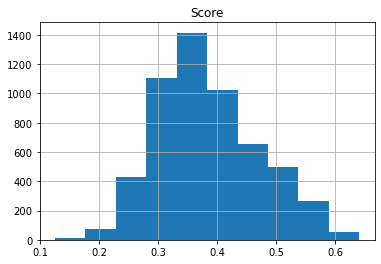

In [73]:
sorted_df_HSI.hist(column="Score")

Looking at the best ones:

In [76]:
sorted_df_HSI[['City','State','Score']].head(10)

,City,State,Score
0,ALTO TAQUARI,MT,0.640908
1,COSTA RICA,MS,0.638561
2,JARDIM OLINDA,PR,0.631036
3,CACHOEIRA DOURADA,MG,0.629665
4,CHAPADÃO DO CÉU,GO,0.627701
5,PEROLÂNDIA,GO,0.627138
6,LAGOA NOVA,RN,0.622598
7,ANGÉLICA,MS,0.617065
8,IPIAÇU,MG,0.616789
9,ADOLFO,SP,0.616710


And the worst ones:

In [77]:
sorted_df_HSI[['City','State','Score']].tail(10)

,City,State,Score
5522,CARAPICUÍBA,SP,0.174390
5523,EMBU-GUAÇU,SP,0.169761
5524,IVOTI,RS,0.168611
5525,SAPIRANGA,RS,0.165910
5526,SAPUCAIA DO SUL,RS,0.165537
5527,RIBEIRÃO PIRES,SP,0.165185
5528,BENEVIDES,PA,0.164631
5529,ESTÂNCIA VELHA,RS,0.160454
5530,MARITUBA,PA,0.130993
5531,CAIEIRAS,SP,0.125449


## 6. Escape Route

We finally get to the fun part! We have the HSI score for all cities and we have the list of neighbors. A city will be selected as a starting point and then we will simulate 1000 agents trying to escape from there. There are two rules to our agent:
1. The probability of going from one city to another is determined by the scores of each of its neighbor and the score from the current city. For example, the city A (score 0.34) has two neighbors, B (0.54) and C (0.37). The probability of staying at A is 0.34/(0.34+0.54+0.37), 27.2%. Moving to B is 43.2%, and for C, 29.6%.
2. The agent will run until it visits the same city five times. That might mean it is stuck in a loop, it has reached a maximum, local or global.

We will have two results:
1. The escape route that ends in the city with higher score;
2. The heatmap showing how many times each city was visited.